In [20]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [21]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
from scipy import ndimage
from skimage import filters
import pims
import trackpy as tp
import os
from skimage.transform import probabilistic_hough_line

######
#to prevent deprecation warnings to be displayed
from numba.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
######

In [22]:
#Opening the first picture of the stack
#frames=pims.open('C:/Users/Faustine/Desktop/Flagella_tracking/Flagella_tracking/Images/*.tif')
#frames=pims.open('C:/Users/Faustine/Desktop/Flagella_tracking/Flagella_tracking/Test/*.tif')
#frames=pims.open('C:/Users/Faustine/Desktop/Flagella_tracking/Traitements/51firstimg_cropped/threshold_triangle_fill/*.tif')
frames=pims.open('C:/Users/Faustine/Desktop/Flagella_tracking/Crop_total/TREAT_triangle/*.tif')
#frames=pims.open('../Images/*.tif')

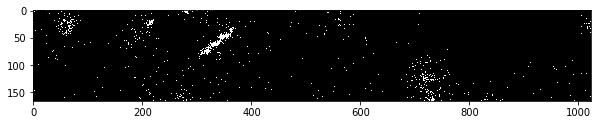

In [23]:
#Display the first picture of the stack. Axes units are pixels.
plt.imshow(frames[45])

In [317]:
# def pipeline2(func): #pseudo code just to understand how a decorator works
#     def wrapper(img):
#         open video
#         [] = out
#         for loopp frames:
#             out += func(img),
#         return out
#     return wrapper

In [338]:
@pims.pipeline #with the pipeline decorator data is only accessed one element at a time
def preprocess(img):
    """Apply image processing functions to return a binary image"""
    #median filtering
    img=ndimage.filters.median_filter(img,size=2)
    #normalized intensity
    norm=(img-img.min())/float(img.max()-img.min())
    #binarization with threshold
    #test threshold
    thresh=0.40
    #Francesca threshold
    #thresh=0.46
    norm[norm>thresh]=1.0
    norm[norm<thresh]=0.0
    return norm

In [24]:
#Apply binarization
imm=preprocess(frames)

NameError: name 'preprocess' is not defined

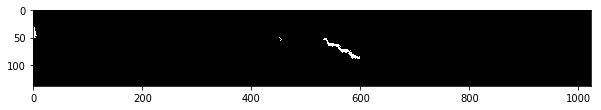

In [340]:
#Display binarization
plt.imshow(imm[70])

In [24]:
#test code line
lines=probabilistic_hough_line(frames[45],threshold=50,line_length=60,line_gap=3)
#Francesca line
#lines=probabilistic_hough_line(imm[0],threshold=30,line_length=55,line_gap=1) #probabilistic line detection

2


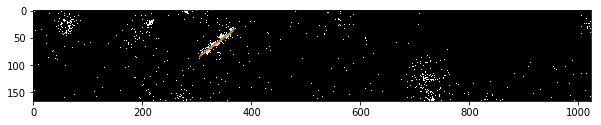

In [29]:
print (len(lines))
P0=[]
P1=[]
for line in lines:
    p0,p1=line
    P0.append(p0)
    P1.append(p1)
    plt.plot((p0[0], p1[0]),(p0[1], p1[1]))
    #plt.plot(line)
plt.imshow(frames[45])
#frames[0] au lieu de imm[0]

(0, 1000)

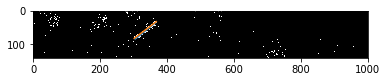

In [7]:
#zoom in interesting zone
for line in lines:
    p0,p1=line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.imshow(frames[45])
#frames[0] au lieu de imm[0]

plt.ylim(140,0)
plt.xlim(0,1000)

#Images_worked
#plt.ylim(500,300)
#plt.xlim(900,1300)

In [8]:
CENTROID_X=[]
CENTROID_Y=[]
nolist=[]
for idx1 in np.arange(0,len(P0)-1):
    if idx1 not in nolist:
        CENTROID_X.append((P0[idx1][0]+P1[idx1][0])/2.0)
        CENTROID_Y.append((P0[idx1][1]+P1[idx1][1])/2.0)
        for idx2 in np.arange(idx1+1,len(P0)):
            if ((P0[idx1][0]-P0[idx2][0])*(P0[idx1][0]-P0[idx2][0]))<20*20:
                nolist.append(idx2) 

[335.5] [59.5]


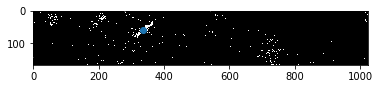

In [9]:
plt.scatter(CENTROID_X,CENTROID_Y)
plt.imshow(frames[45])
#frames[0] au lieu de imm[0]
print (CENTROID_X,CENTROID_Y)

NameError: name 'imm' is not defined

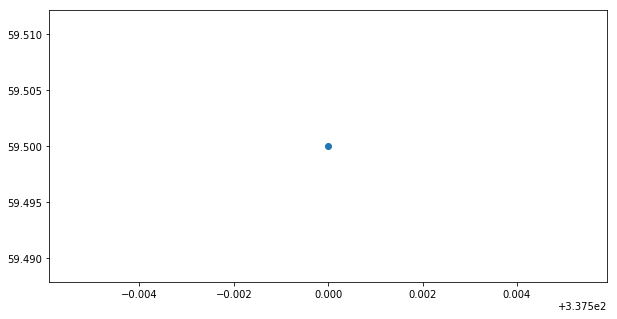

In [70]:
plt.scatter(CENTROID_X,CENTROID_Y)
plt.imshow(imm[-1])
print (CENTROID_X,CENTROID_Y)
#Images_worked
#plt.ylim(500,300)
#plt.xlim(900,1300)
plt.ylim(140,0)
plt.xlim(0,1000)
plt.title('centroid line last image')

In [39]:
#try to apply the same analysis to all figures in the stack
features=pd.DataFrame()
for num, img in enumerate(frames):
#for num,img in enumerate(imm):
#s'arrête quand il a atteint un nombre d'images analysées = nb d'img total, mais peut analyser 2x la même img !
#et dans ce cas, s'arrête avant la fin des images puisque le nb d'img analysées > nb img total...
    #test code line
    lines=probabilistic_hough_line(img,threshold=50,line_length=70,line_gap=3) #probabilistic line detection
    #Francesca line
    #lines=probabilistic_hough_line(img,threshold=20,line_length=55,line_gap=1) #probabilistic line detection
    P0=[]
    P1=[]
    for line in lines:
        p0,p1=line
        P0.append(p0)
        P1.append(p1)
    CENTROID_X=[]
    CENTROID_Y=[]
    nolist=[]
    for idx1 in np.arange(0,len(P0)-1):
        if idx1 not in nolist:
            CENTROID_X.append((P0[idx1][0]+P1[idx1][0])/2.0)
            CENTROID_Y.append((P0[idx1][1]+P1[idx1][1])/2.0)
            #rajout Faustine: lengthinmicrons
            lengthinmicrons=np.linalg.norm((P1[idx1][0]-P0[idx1][0],P1[idx1][1]-P0[idx1][1]))
            for idx2 in np.arange(idx1+1,len(P0)):
                if ((P0[idx1][0]-P0[idx2][0])*(P0[idx1][0]-P0[idx2][0]))<20*20:
                    nolist.append(idx2)   
    # Store features which survived to the criterions
    for nn,cx in enumerate(CENTROID_X):
        features = features.append([{'y': CENTROID_Y[nn],
                                     'x': cx,
                                     'frame':num,
                                     #rajouts par Faustine
                                     'length':lengthinmicrons,
                                     },])

In [40]:
features

,frame,length,x,y
0,0,85.005882,207.5,52.5
0,1,86.000000,198.5,52.5
0,1,86.000000,197.0,54.0
0,2,87.051709,184.0,50.0
0,2,87.051709,183.5,48.5
0,3,82.054860,169.0,50.5
0,4,82.006097,156.5,52.0
0,4,82.006097,154.0,53.5
0,5,76.000000,140.0,50.5
0,5,76.000000,143.0,55.0


In [73]:
#Saving features as a table in .csv to exploit it later in Excel
featurescsv = pd.DataFrame(features, columns = ['frame', 'x', 'y'])
featurescsv.to_csv('C:/Users/Faustine/Desktop/Flagella_tracking/features.csv')

Frame 1112: 39 trajectories present


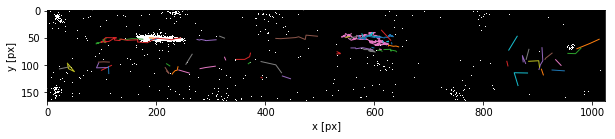

In [74]:
t = tp.link_df(features, search_range=30, memory=5)
tp.plot_traj(t, superimpose=frames[0])

In [75]:
t.head()

,frame,x,y,particle
0,0,203.0,50.5,0.0
1,1,197.0,53.5,0.0
2,2,189.0,52.5,0.0
3,1,195.5,50.5,1.0
4,2,187.0,50.0,1.0


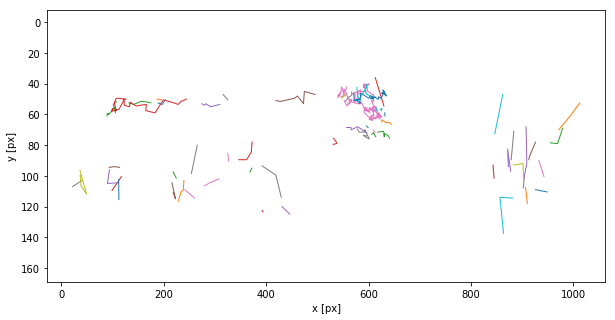

In [76]:
tp.plot_traj(t)

In [146]:
unstacked = t.set_index(['frame', 'particle']).unstack()

In [147]:
unstacked

x                                                          \
particle  0.0    1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0     
frame                                                                     
0         207.0  193.5  328.5  424.0  217.0  507.5  318.0  275.5  425.0   
1         199.5  185.5  318.0  403.0  207.0  511.0  303.0  249.5    NaN   
2         188.0  183.5  295.0  378.5  206.0  511.0  294.0  221.0    NaN   
3         194.0    NaN  280.0  354.5    NaN  508.5  282.5    NaN    NaN   
4           NaN    NaN    NaN  329.5    NaN    NaN  273.5    NaN    NaN   
5           NaN    NaN    NaN  307.5    NaN  505.5    NaN    NaN    NaN   
6           NaN    NaN  286.0    NaN    NaN  510.5    NaN    NaN    NaN   
7           NaN    NaN  268.5    NaN    NaN  511.5    NaN    NaN    NaN   
8           NaN    NaN  250.0    NaN    NaN  515.0    NaN    NaN    NaN   
9           NaN    NaN  235.0    NaN    NaN  519.5    NaN    NaN    NaN   
10          NaN    NaN  219.0    NaN    NaN    NaN  250.0    NaN    NaN   
11          NaN    NaN  203.0    NaN    NaN    NaN  256.5    NaN    NaN   
12          NaN    NaN  189.0    NaN    NaN    NaN  261.0    NaN    NaN   
13          NaN    NaN  178.0    NaN    NaN    NaN  259.5    NaN    NaN   
14          NaN    NaN    NaN    NaN    NaN    NaN  263.0    NaN    NaN   
15          NaN    NaN    NaN    NaN    NaN    NaN  261.5    NaN    NaN   
16          NaN    NaN    NaN    NaN    NaN    NaN  268.5    NaN    NaN   
17          NaN    NaN    NaN    NaN    NaN    NaN  271.5    NaN    NaN   
18          NaN    NaN    NaN    NaN    NaN    NaN  273.0    NaN    NaN   
19          NaN    NaN    NaN    NaN    NaN    NaN  279.5    NaN    NaN   
20          NaN    NaN    NaN    NaN    NaN    NaN  292.0    NaN    NaN   
21          NaN    NaN    NaN    NaN    NaN    NaN  292.5    NaN    NaN   
22          NaN    NaN    NaN    NaN    NaN    NaN  303.0    NaN    NaN   
23          NaN    NaN    NaN    NaN    NaN    NaN  315.0    NaN    NaN   
24          NaN    NaN    NaN    NaN    NaN    NaN  324.5    NaN    NaN   
25          NaN    NaN    NaN    NaN    NaN    NaN  332.5    NaN    NaN   
26          NaN    NaN    NaN    NaN    NaN    NaN  342.5    NaN    NaN   
27          NaN    NaN    NaN    NaN    NaN    NaN  355.0    NaN    NaN   
28          NaN    NaN    NaN    NaN    NaN    NaN  369.5    NaN    NaN   
29          NaN    NaN    NaN    NaN    NaN    NaN  380.5    NaN    NaN   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
69          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
70          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
71          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
72          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
73          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
74          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
75          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
76          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
77          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
78          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
80          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
81          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
82          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
83          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
84          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
85          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
86          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
87          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
88          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
89          NaN    NaN    NaN    NaN   